<a href="https://colab.research.google.com/github/osilian/ml4sc-project/blob/master/disc-benchmark-files/identification_NARX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load required packages
import torch
from torch import nn
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = False
import numpy as np

print(torch.accelerator.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

!nvidia-smi

1
Wed Jun 11 09:03:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+---

### Create Datasets and apply Preprocessing

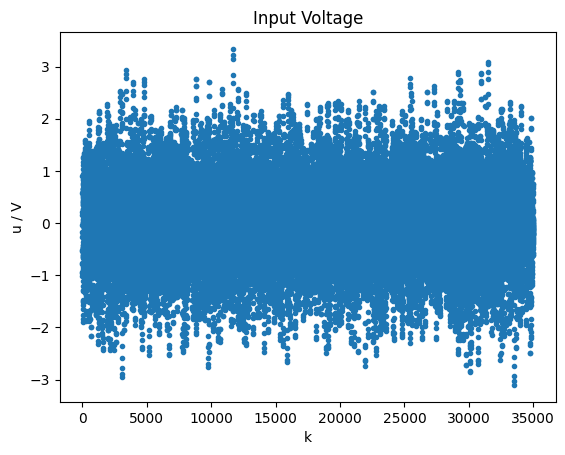

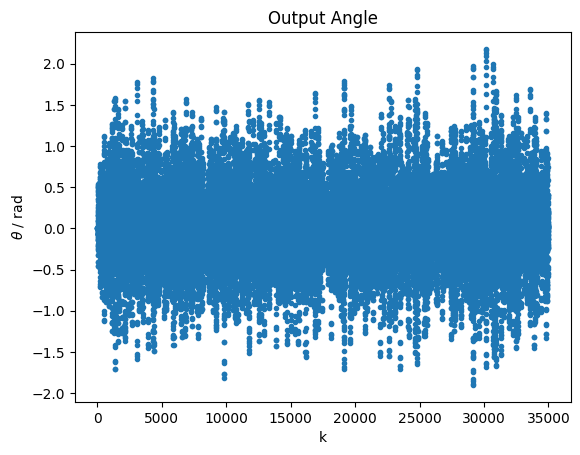

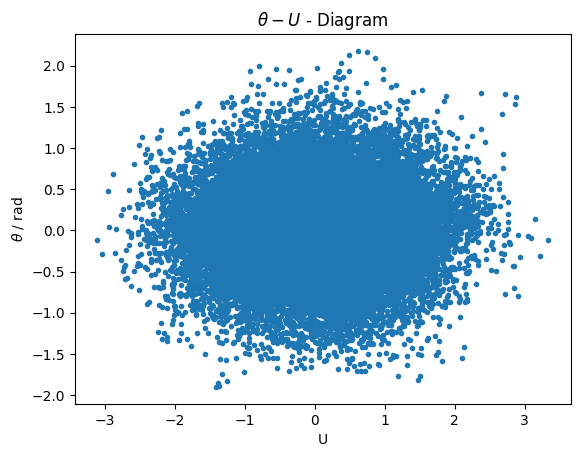

In [2]:
# Load Benchmark Data

out = np.load('training-val-test-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

# Plot Data
plt.plot(u_train,'.')
plt.title('Input Voltage')
plt.xlabel('k')
plt.ylabel('u / V')
plt.show()

plt.plot(th_train,'.')
plt.title('Output Angle')
plt.xlabel('k')
plt.ylabel(r'$\theta$ / rad')
plt.show()

plt.plot(u_train,th_train,'.')
plt.title(r'$\theta - U$ - Diagram')
plt.xlabel('U')
plt.ylabel(r'$\theta$ / rad')
plt.show()


def create_IO_data(u,y,na,nb):
    X = []
    Y = []
    for k in range(max(na,nb), len(y)):
        X.append(np.concatenate([u[k-nb:k],y[k-na:k]]))
        Y.append(y[k])
    return np.array(X), np.array(Y)
'''
# Apply Preprocessing - normalization
u_mean = np.mean(u_train)
th_mean = np.mean(th_train)
u_std  = np.std(u_train)
th_std = np.std(th_mean)
u_train = (u_train-u_mean)/u_std
th_train = (th_train - th_mean)/th_std
'''
def create_search_data(na, nb, uTrain=u_train, yTrain=th_train, testSize=0.2):
    # Create Time-Series Datasets
    Xdata, Ydata = create_IO_data(uTrain, yTrain, na, nb)

    # split into training in validation data
    from sklearn import model_selection
    Xtrain, Xval, Ytrain, Yval = model_selection.train_test_split(Xdata, Ydata, shuffle=True, test_size=testSize,random_state=42)

    Xtrain, Xval, Ytrain, Yval = [torch.as_tensor(x,dtype=torch.float32,device=device) for x in [Xtrain, Xval, Ytrain, Yval]] #convert it to torch arrays
    return Xtrain, Xval, Ytrain, Yval



### Create and Train NARX NN

In [3]:
class narxNetwork(nn.Module):
    def __init__(self, na, nb, n_hidden_nodes,activation=nn.Sigmoid): #a)
        super(narxNetwork,self).__init__() #a)
        #self.lay1 = nn.Linear(n_in,n_hidden_nodes).double() #a)
        #self.lay2 = nn.Linear(n_hidden_nodes,1).double() #a)

        seq = [nn.Linear(na+nb,n_hidden_nodes), activation()]
        seq.append(nn.Linear(n_hidden_nodes,1))

        self.narx_net = nn.Sequential(*seq)


    def forward(self,x): #a)
        #x = concatenated [upast and ypast] #a)
        y = self.narx_net(x)[:,0]
        return y #a)






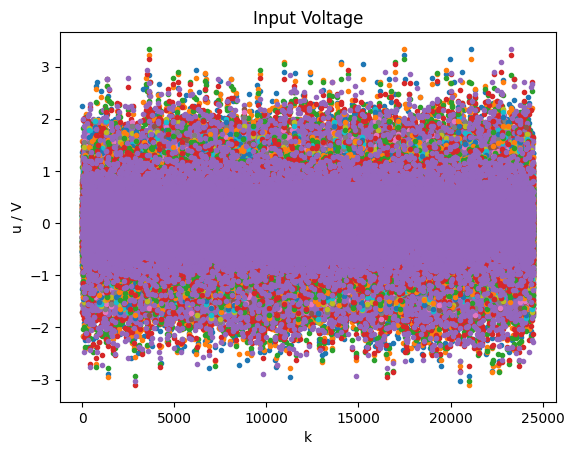

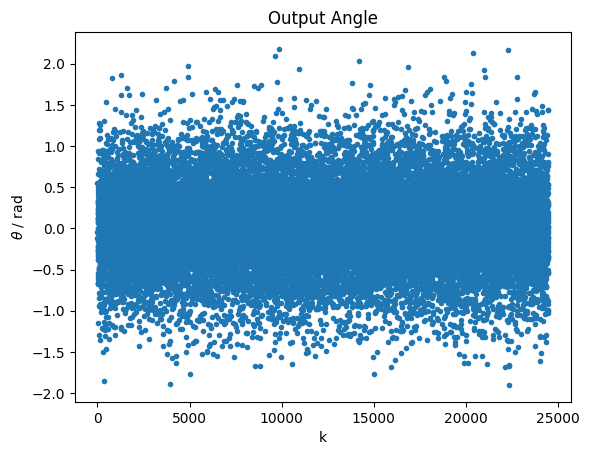

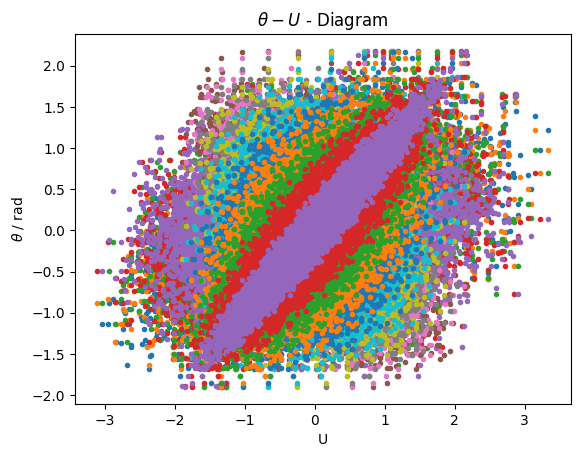

In [31]:
n_hidden_nodes = 100 #a)
na, nb = 10, 5
model = narxNetwork(na, nb, n_hidden_nodes,activation=nn.ReLU) #a=)
model = nn.DataParallel(model)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters()) #a)
Xtrain, Xval, Ytrain, Yval = create_search_data(na, nb, testSize=0.3)
x_train_mean = torch.mean(Xtrain).item()
x_train_std = torch.std(Xtrain).item()
y_train_mean = torch.mean(Ytrain).item()
y_train_std = torch.std(Ytrain).item()
class dataNormalization():
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max

    def normalize(self, XData, YData):
        #Xnorm = 2 * (XData - self.x_min) / (self.x_max - self.x_min) - 1 # -1 and * 2 to always normalize into (-1,1) no matter what the smallest x_min is
        #Ynorm = 2 * (YData - self.y_min) / (self.y_max - self.y_min) - 1
        # Xnorm = (XData-x_train_mean)/x_train_std
        # Ynorm = (YData-y_train_mean)/y_train_std
        Xnorm = XData
        Ynorm = YData
        return Xnorm, Ynorm

    def denormalize(self, YData_norm):
        #YData = 0.5 * (YData_norm + 1) * (self.y_max - self.y_min) + self.y_min
        #YData = YData_norm*y_train_std + y_train_mean
        YData = YData_norm
        return YData
x_min = -3 #torch.min(torch.min(Xtrain)).item()
x_max = +3 #torch.max(torch.min(Xtrain)).item()
y_min = -2/3*np.pi  #torch.min(torch.min(Ytrain)).item()
y_max = +2/3*np.pi   #torch.max(torch.min(Ytrain)).item()
dataNorm = dataNormalization(x_min,x_max,y_min,y_max)

Xtrain_norm, Ytrain_norm = dataNorm.normalize(Xtrain, Ytrain)
#Xtrain_norm, Ytrain_norm = [x.to(device) for x in [Xtrain_norm, Ytrain_norm]]

# Plot Data
plt.plot(Xtrain_norm.cpu(),'.')
plt.title('Input Voltage')
plt.xlabel('k')
plt.ylabel('u / V')
plt.show()

plt.plot(Ytrain_norm.cpu(),'.')
plt.title('Output Angle')
plt.xlabel('k')
plt.ylabel(r'$\theta$ / rad')
plt.show()

plt.plot(Xtrain_norm.cpu(),Ytrain_norm.cpu(),'.')
plt.title(r'$\theta - U$ - Diagram')
plt.xlabel('U')
plt.ylabel(r'$\theta$ / rad')
plt.show()


In [32]:

epochs = 20*10**3 #a)
for epoch in range(epochs): #a)
    Loss = torch.mean((model(Xtrain_norm)-Ytrain_norm)**2) #a)
    optimizer.zero_grad() #a)
    Loss.backward() #a)
    optimizer.step() #a)
    if epoch%1000==0: #a) monitor
        print(epoch,Loss.item()) #a)


0 0.26228171586990356
1000 0.00015526531205978245
2000 5.680787580786273e-05
3000 3.528025627019815e-05
4000 2.5615938284317963e-05
5000 1.8659715351532213e-05
6000 1.4632234524469823e-05
7000 1.2110875104553998e-05
8000 1.719812826195266e-05
9000 9.736153515405022e-06
10000 9.48788056120975e-06
11000 1.3414833119895775e-05
12000 8.353370503755286e-06
13000 7.995183295861352e-06
14000 7.971914783411194e-06
15000 7.666330930078402e-06
16000 7.656498382857535e-06
17000 9.386025340063497e-06
18000 7.487491529900581e-06
19000 7.808524060237687e-06


In [6]:

# Code from Exercise Set L3
def fit(net, X_data, Y_data, X_val, Y_val, lr, epochs=10*10**3):
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    best_state = None
    best_loss = float('inf')

    for epoch in range(1,epochs+1):
        loss = torch.mean((net(X_data)-Y_data)**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch%1000==0:
            loss_val = torch.mean((net(X_val)-Y_val)**2).item()**0.5 #RMS
            if loss_val<best_loss:
                from copy import deepcopy
                best_state = deepcopy(net.state_dict())
                best_loss = loss_val
            print(f'epoch={epoch:5}, loss={loss.item()**0.5:.2f}')
    if best_state:
        net.load_state_dict(best_state)
    return net

import functools
@functools.lru_cache(maxsize=500, typed=False)
def test(X_train, Y_train, X_val, Y_val, na=2, nb=2, n_hidden_nodes=20, activation=nn.Tanh, lr=1e-3):
    net = narxNetwork(na, nb, n_hidden_nodes, activation) #a=)
    net = nn.DataParallel(net)
    net = net.to('cuda')
    net = fit(net, X_train, Y_train, X_val, Y_val, lr) #a=)
    RMS = torch.mean((net(X_val)-Y_val)**2).item()**0.5 #a=)
    return RMS #a=)


current_best = dict(na=5, nb=5, n_hidden_nodes=5, activation=nn.Sigmoid, lr=1e-3)
choices_dict = dict(na=[5,10,15], \
                nb=[5,10,15], \
                n_hidden_nodes=[5, 10, 15, 20, 30, 50, 75, 100], \
                activation=[nn.Sigmoid, nn.Tanh, nn.ReLU], \
                lr = [1e-3]
                )
import itertools
gridKeys = choices_dict.keys()
grid = list(itertools.product(*choices_dict.values()))

# rmse_matrix = np.zeros((len(choices_dict["na"]), len(choices_dict["nb"])))

best_score = float('inf')
best_params = None
results = []
import copy
for params in grid:
    choice = dict(zip(gridKeys,params))
    # now = copy.deepcopy(current_best) #create a new dict
    # now[name] = choice #put choice in the correct place
    print('optimizing...',choice)

    # create dataset
    Xtrain, Xval, Ytrain, Yval = create_search_data(choice['na'],choice['nb'])
    Xtrain_norm, Ytrain_norm = dataNorm.normalize(Xtrain, Ytrain)
    Xval_norm, Yval_norm = dataNorm.normalize(Xval,Yval)
    rmse = test(Xtrain_norm, Ytrain_norm, Xval_norm, Yval_norm,**choice)
    results.append((choice, rmse)) #add it to results

    #print('done with loop for option', name)
    #print('\n'.join([f'choice={c} result={r:.5}' for c,r in zip(choices,results)]))
    # pick = choices[np.argmin(results)]
    # print(f'picking = {pick} {name}')
    #current_best[name] = pick

    if rmse < best_score:
        best_score = rmse
        best_params = choice



optimizing... {'na': 5, 'nb': 5, 'n_hidden_nodes': 5, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>, 'lr': 0.001}
epoch= 1000, loss=0.05
epoch= 2000, loss=0.04
epoch= 3000, loss=0.03
epoch= 4000, loss=0.02
epoch= 5000, loss=0.01
epoch= 6000, loss=0.01
epoch= 7000, loss=0.01
epoch= 8000, loss=0.01
epoch= 9000, loss=0.01
epoch=10000, loss=0.01
optimizing... {'na': 5, 'nb': 5, 'n_hidden_nodes': 5, 'activation': <class 'torch.nn.modules.activation.Tanh'>, 'lr': 0.001}
epoch= 1000, loss=0.04
epoch= 2000, loss=0.03
epoch= 3000, loss=0.03
epoch= 4000, loss=0.02
epoch= 5000, loss=0.02
epoch= 6000, loss=0.01
epoch= 7000, loss=0.01
epoch= 8000, loss=0.01
epoch= 9000, loss=0.01
epoch=10000, loss=0.01
optimizing... {'na': 5, 'nb': 5, 'n_hidden_nodes': 5, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.001}
epoch= 1000, loss=0.03
epoch= 2000, loss=0.02
epoch= 3000, loss=0.01
epoch= 4000, loss=0.01
epoch= 5000, loss=0.01
epoch= 6000, loss=0.01
epoch= 7000, loss=0.01
e

In [11]:
import pickle
with open("grid_search","wb") as f:
  pickle.dump(results,f)

print(best_params)
model = narxNetwork(best_params['na'],best_params['nb'],best_params['n_hidden_nodes'],best_params['activation'])
model = nn.DataParallel(model)
model = model.to('cuda')
na, nb = best_params['na'], best_params['nb']

Xtrain, Xval, Ytrain, Yval = create_search_data(best_params['na'],best_params['nb'],testSize=0.3)
Xtrain_norm, Ytrain_norm = dataNorm.normalize(Xtrain, Ytrain)
Xval_norm, Yval_norm = dataNorm.normalize(Xval,Yval)

optimizer = torch.optim.Adam(model.parameters())
epochs = 20*10**3 #a)
for epoch in range(epochs): #a)
    Loss = torch.mean((model(Xtrain_norm)-Ytrain_norm)**2) #a)
    optimizer.zero_grad() #a)
    Loss.backward() #a)
    optimizer.step() #a)
    if epoch%1000==0: #a) monitor
        print(epoch,Loss.item()) #a)

{'na': 10, 'nb': 5, 'n_hidden_nodes': 100, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.001}
0 0.34593263268470764
1000 0.00015456219261977822
2000 6.261981616262347e-05
3000 3.837991607724689e-05
4000 2.622104511829093e-05
5000 1.8104354239767417e-05
6000 1.52684333443176e-05
7000 1.2008293197141029e-05
8000 1.0639490028552245e-05
9000 9.740944733493961e-06
10000 1.5797904779901728e-05
11000 8.866031748766545e-06
12000 8.252100087702274e-06
13000 8.086488378467038e-06
14000 1.5748128134873696e-05
15000 1.0434647265356034e-05
16000 7.653102329641115e-06
17000 7.947452104417607e-06
18000 7.818097401468549e-06
19000 7.369076229224447e-06


train prediction errors:
RMS: tensor(0.0027, device='cuda:0') radians
RMS: tensor(0.1542, device='cuda:0') degrees
NRMS: tensor(0.5616, device='cuda:0') %


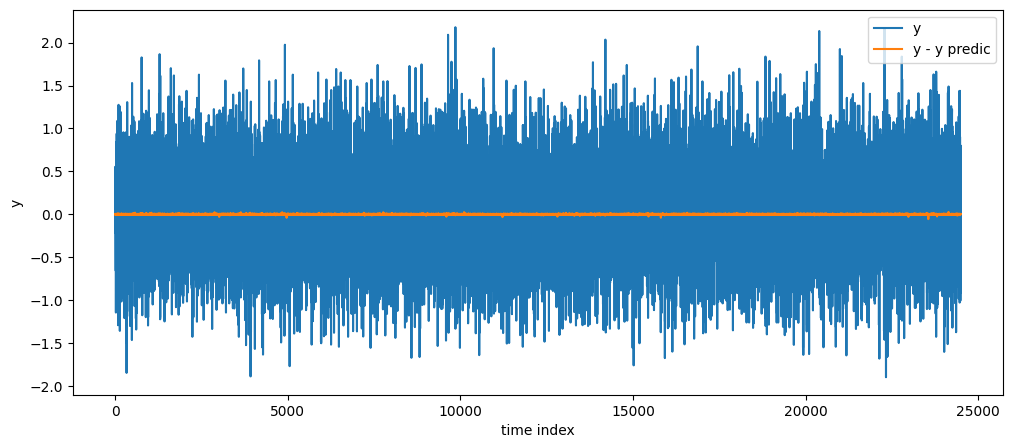

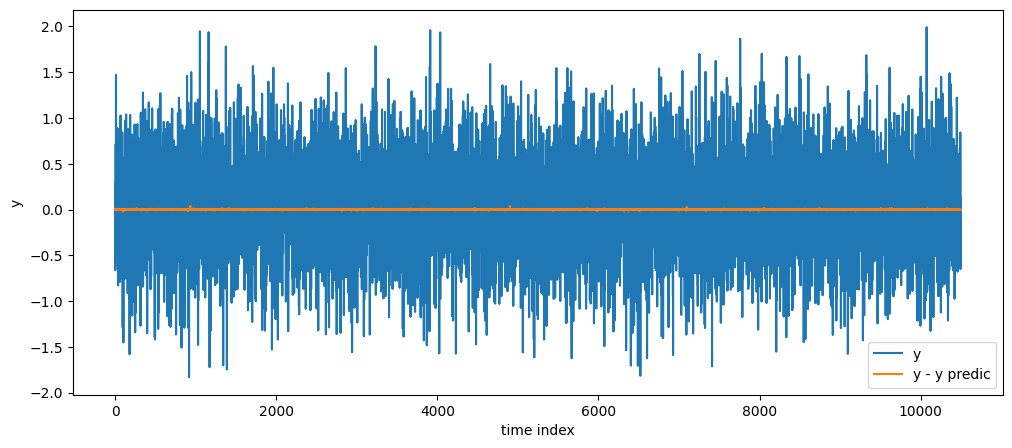

validation prediction errors:
RMS: tensor(0.0028, device='cuda:0') radians
RMS: tensor(0.1587, device='cuda:0') degrees
NRMS: tensor(0.5776, device='cuda:0') %


In [33]:

#residual calculations and plotting
with torch.no_grad():
    Ytrain_pred_norm = model(Xtrain_norm)
    Ytrain_pred = dataNorm.denormalize(YData_norm=Ytrain_pred_norm)
    Ytrain = Ytrain.to('cuda')
    print('train prediction errors:')
    print('RMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5,'radians')
    print('RMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5/Ytrain.std()*100,'%')
    res = Ytrain_pred - Ytrain #b)
    plt.figure(figsize=(12,5)) #b)
    plt.plot(Ytrain.cpu()) #b)
    plt.plot(res.cpu()) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    plt.show() #b)

    Xval_norm, _ = dataNorm.normalize(XData=Xval, YData=Yval)
    Yval_pred_norm = model(Xval_norm)
    Yval_pred = dataNorm.denormalize(Yval_pred_norm)
    Yval = Yval.to('cuda')
    res = Yval_pred - Yval #b)
    plt.figure(figsize=(12,5)) #b)
    plt.plot(Yval.cpu()) #b)
    plt.plot(res.cpu()) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    plt.show() #b)
    print('validation prediction errors:')
    print('RMS:', torch.mean((Yval_pred-Yval)**2)**0.5,'radians')
    print('RMS:', torch.mean((Yval_pred-Yval)**2)**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Yval_pred-Yval)**2)**0.5/Yval.std()*100,'%')

trained simulation errors:
RMS: 0.5984352575216835 radians
RMS: 34.287814567817016 degrees
NRMS: 118.93593999925749 %


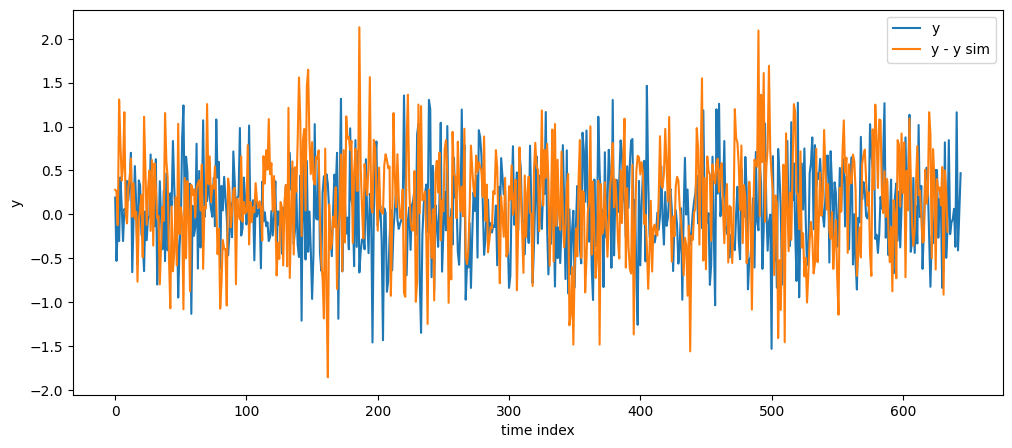

test simulation errors:
RMS: 0.6026470423833963 radians
RMS: 34.52913206461025 degrees
NRMS: 119.77301065194092 %


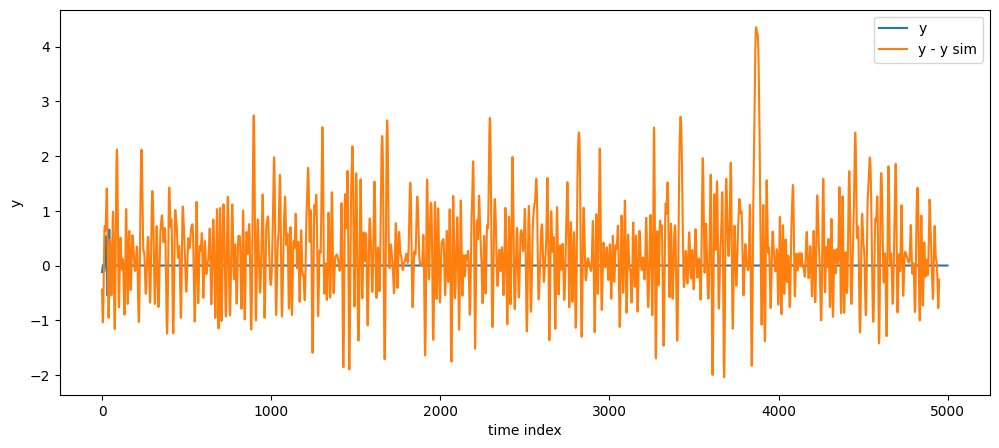

In [34]:
# Set up simulation for identified net
#### What's done with the na and nb here???
# Simulation Test
out = np.load('/content/hidden-test-prediction-submission-file.npz')
th_train = out['thpast'][:,0] #th[0],th[1],th[2],th[3],...
u_train = out['upast'][:,0] #u[0],u[1],u[2],u[3],...

data = np.load('/content/hidden-test-simulation-submission-file.npz')
u_test = data['u']
th_test = data['th'] #only the first 50 values are filled the rest are zeros

def simulation_IO_model(f, ulist, ylist, skip=50):
    upast = ulist[skip-na:skip].tolist() #good initialization
    ypast = ylist[skip-nb:skip].tolist()
    Y = ylist[:skip].tolist()
    for u in ulist[skip:]:
        x = np.concatenate([upast,ypast],axis=0)
        x = torch.as_tensor(x,dtype=torch.float32, device=device)
        x_norm,_ = dataNorm.normalize(x,x)
        ypred = f(x_norm).cpu()
        ypred = ypred.detach().numpy()
        Y.append(ypred)
        upast.append(u)
        upast.pop(0)
        ypast.append(ypred)
        ypast.pop(0)
    return dataNorm.denormalize(np.array(Y))

skip = max(na,nb)
th_train_sim = simulation_IO_model(lambda x: model(x[None,:])[0], u_train, th_train, skip=skip)
print('trained simulation errors:')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5,'radians')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5/th_train.std()*100,'%')
# Plotting
res = th_train_sim[skip:] - th_train[skip:] #b)
plt.figure(figsize=(12,5)) #b)
plt.plot(th_train) #b)
plt.plot(res) #b)
plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y sim'])#b)
plt.show() #b)

skip = 50
th_test_sim = simulation_IO_model(lambda x: model(x[None,:])[0], u_test, th_test, skip=skip)
print('test simulation errors:')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5,'radians')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5/th_train.std()*100,'%')
# Plotting
res = th_test_sim[skip:] - th_test[skip:] #b)
plt.figure(figsize=(12,5)) #b)
plt.plot(th_test) #b)
plt.plot(res) #b)
plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y sim'])#b)
plt.show() #b)

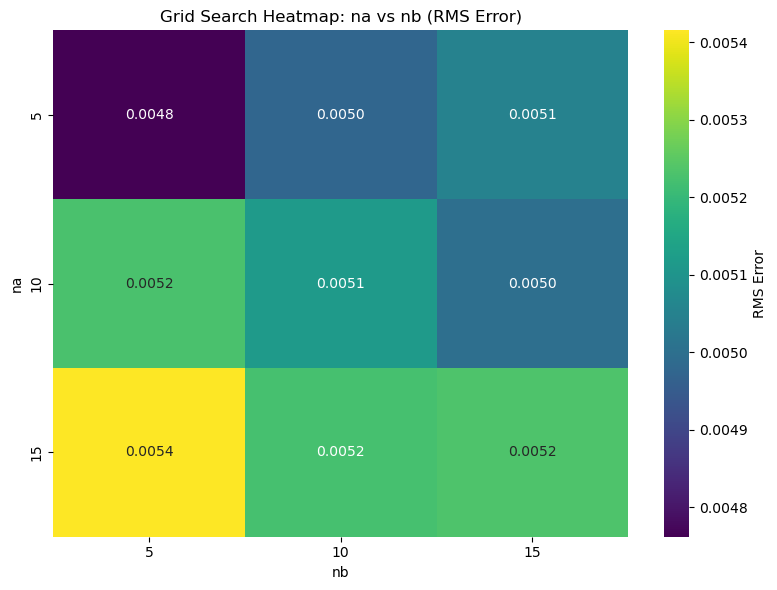

In [ ]:
# import saved grid search
import pickle

file_path = 'grid_search'

with open(file_path, 'rb') as f:
    results_grid = pickle.load(f)

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# for activation and hidden_nodes not specified, uses averaging
df = pd.DataFrame([
    {'na': params['na'], 'nb': params['nb'], 'RMS': rms}
    for params, rms in results_grid
])

pivot_table = df.pivot_table(index='na', columns='nb', values='RMS')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'RMS Error'})
plt.title('Grid Search Heatmap: na vs nb (RMS Error)')
plt.xlabel('nb')
plt.ylabel('na')
plt.tight_layout()
plt.show()
